<a href="https://colab.research.google.com/github/RachelRamirez/tta/blob/main/TTA_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparison of 4 Techniques** Traditional CNN (baseline),  2 "Bayesian" CNNs, and Test-Time Augmentations on CIFAR-9 classes and one novel class

This is a resource originally about Bayesian Neural Networks,  by TensorChiefs found as supplemental coding material for their book [Probabilistic Deep Learning](https://tensorchiefs.github.io/dl_book/), their original code is [here](https://colab.research.google.com/drive/1ZCNuGd9z_ZvJ7irFH-FQmqlFXP5jeK8z#scrollTo=TNFhkloWTImi).  I  added and compared Test Time Augmentation.

Future: I plan to add [time and memory run profiles](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb#scrollTo=HdeOK7Qhw0wp) to also compare the methods

In [ ]:
#@title Just do TTA experiments? { display-mode: "form" }
#@markdown This Colab will skip everything but TTA if checked
just_TTA  = True #@param {type: "boolean"} 

if just_TTA:
  print("Will skip everything but TTA experiments")

Will skip everything but TTA experiments


# Cifar10 classification case study with novel class

**Goal:** In this notebook you will investigate which advantages Bayesian NNs can offer in a classification task. You will use train data from 9 of the 10 classes in the Cifar10 dataset to fit different three probabilistic NN.
First you fit a "traditional" non-Bayesian NN and then you will fit two Bayesian NN, one via variational inference and one via dropout. You will compare the accuracy of the different NN on the 9 known classes. Further you will investigate and compare the uncertainties expressed by the NNs for both the known classes and unknown class. Finally you will use these uncertainties to detect novel classes and filter out uncertain predictions.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"). You will delete all images from the class "horse" in the training dataset to simulate a novel class. Note that we keep the class "horse" in the test dataset.

**Content:**
* Load the Cifar10 dataset
* Delete all images of the class "horse" from the training dataset
* Split the train dataset into a train and validation dataset (60:40 split) 
* Fit a non-Bayesian NN 
* Fit a Bayesian NN via variational inference 
* Fit a Bayesian NN via dropout 
* Compare the  of the accuracy of the models on the known classes
* Compare the  of the uncertainties of the models on the known and unknown classes
* Use the uncertainties to filter uncertain predictions

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_04.ipynb)

In [ ]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.9.2  running in colab?:  True


In [ ]:
# I commented this out because I think there are too many outdated dependencies

# if IN_COLAB:
#     !pip install tensorflow_probability==0.8.0

#### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import urllib.request
from sklearn.model_selection import train_test_split

#I added this below from StackOverflow to see if it wouldsolve import issues
#https://stackoverflow.com/questions/62743492/cannot-import-tensorflow-probability
# !pip install --upgrade tf_agents

import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

## Adding Test time Augmentation TTA
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

TFP Version 0.17.0
TF  Version 2.9.2


In the next cell you disable the tensorflow eager mode. We need to do this because otherwise we would get errors for the variational inference NN and we  would not be able to turn on and off the dropout in the MC dropout NN.

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

#### Loading and preparation of the dataset

Let's load the cifar 10 dataset. It is already splited into a train and test dataset. To get a feeling for the dataset, you plot a random example of each class of the trainingset. You can see that the images are quite small and its not always easy to see the class on the image.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

<ipython-input-12-012e5f5aa791>:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)


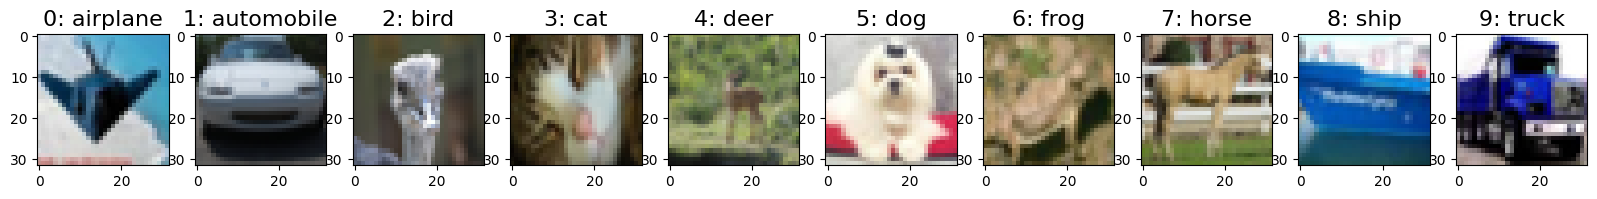

In [ ]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
np.random.seed(22)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)
plt.savefig("Figure_8_cifar.pdf")
#from google.colab import files
#files.download('Figure_8_cifar.pdf') 


To simualte a novel class, you will delete all images of the class "horse" from the traning dataset. Note that you do this only in the trainset, the test dataset stays the same. In the train dataset you will now have 9 classes with 5'000 images of every class, in total 45'000 images. This will be your traning dataset for the three models.   

In [ ]:
y_train_no_horse=np.delete(y_train,np.where(y_train==7)[0])
x_train_no_horse=np.delete(x_train,np.where(y_train==7)[0],axis=0)
print(y_train_no_horse.shape)
print(x_train_no_horse.shape)
y_train_no_horse=np.array(pd.get_dummies(y_train_no_horse))
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])
print(y_train_no_horse.shape)

(45000,)
(45000, 32, 32, 3)
(45000, 9)


Now you split the new training dataset without the horses randomly into a train and validationset. You use a 60:40 ratio for the split, so you have 27'000 train images with 9 classes and 18'000 validation images with 9 classes. The test dataset has 10'000 images and 10 classes. Note that we have a novel (unknown) class "horse" in the testset.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

#Before training the NNs with the data, we normalize the data to be in the range between -1 and 1. 
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2

x_test.min(), x_test.max()

(27000, 32, 32, 3)
(27000, 9)
(18000, 32, 32, 3)
(18000, 9)
(10000, 32, 32, 3)
(10000, 1)


(-1.0, 1.0)

In [ ]:
#Experiment to bring it back to 0 and 255
x_test_exp=((x_test/2)+0.5)*255
x_test_exp.min(), x_test_exp.max()

# Experiment with experument to bring it to 0 and 1.
def revertscale_fn(img):
    img = img.astype(np.float32) / 2
    img = (img + 0.5) * 255
    return img
# gen = ImageDataGenerator(
#     preprocessing_function=revertscale_fn,
#     rescale = 1./255,
# )

## Non-Bayesian CNN

In this section we use a CNN with two convolutional blocks, followed by maxpooling layers. You use 8 kernels with the size 3x3 in the first convolutional block and in the second block you use 16 kernels with the size 3x3. The maxpoolingsize is 2x2 pixels. After the feature extraction you use a flatten layer and do the classification with 3 fully connected layers. Because the training takes a lot of time, you will load an already trained CNN with the learning curve.

In [ ]:
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras import Sequential

model = Sequential()
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(9, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                    

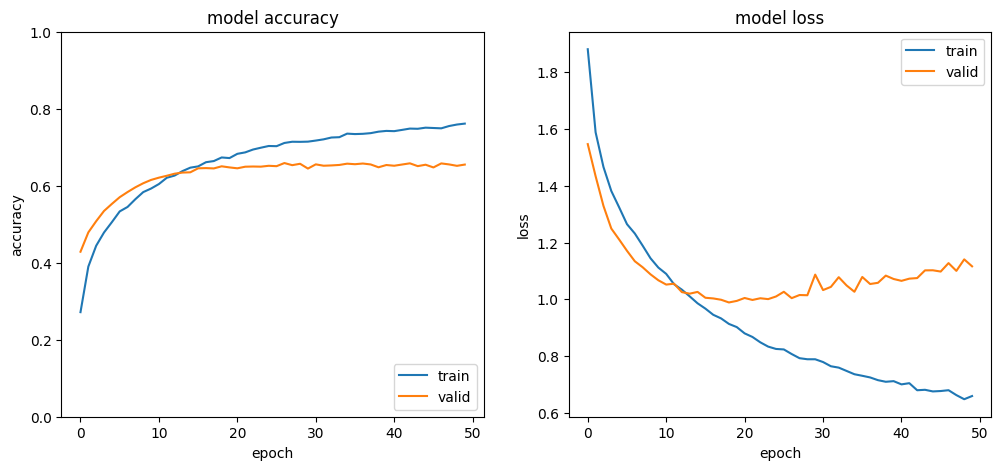

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/history_baseline_cifar10.csv", "history_baseline_cifar10.csv")
history=np.loadtxt("history_baseline_cifar10.csv",delimiter=",")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history[:,2])
plt.plot(history[:,3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
# load trained weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_cifar10_weights.hdf5", "model_cifar10_weights.hdf5")
model.load_weights("model_cifar10_weights.hdf5")

## Variational Inference

Now we will train a bayesian neural network via variational inference. We again use a CNN with two convolutional blocks, followed by maxpooling layers. The setting is the same as above.

Note that every weight in the network is now sampled from a normal distribution. The normal distribution has two paramters and therefore we have almost doubled our paramters (we don't use a distribution for bias terms) in the network.  Because the training takes a lot of time, you will load an already trained CNN with the learning curve.

In [ ]:
if just_TTA:
  print("")  
else:
    kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] *1.0)

    model_vi = Sequential()
    model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
    model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
    model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
    model_vi.add(tf.keras.layers.Flatten())
    model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

    model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    model_vi.summary()

In the next cell you can see that you get a different prediction for the same image, when you predict it multilple times. Everytime you sample each weight with the corresponding parameters and the prediction changes a bit. 

In [ ]:
if just_TTA:
  print("")  
else:
  for i in range(0,5):
    print(model_vi.predict(x_train[0:1])[0])

In [ ]:
# Training
# Note that we trained longer for the VI methods, than for the MC Bayes
# from  tensorflow.keras.callbacks import ModelCheckpoint
# fp = "vi_128_lrdefault_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
# cb = ModelCheckpoint(filepath=fp, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=50)
# history=model_vi.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=700,verbose=1, callbacks=[cb])
# model_vi.save_weights('vi_128_lrdefault.hdf5')
# import pickle
# with open('model_vi_bs_128_lrdefault_hist.pickle', 'wb') as file_pi:
#         pickle.dump(history.history, file_pi)

In [ ]:
# download and load weights of the model
if just_TTA:
  print("")  
else:
  urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/vi_128_lrdefault.hdf5", "vi_128_lrdefault.hdf5")
  model_vi.load_weights("vi_128_lrdefault.hdf5")

  # download the history
  import pickle
  urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_vi_bs_128_lrdefault_hist.pickle", "model_vi_bs_128_lrdefault_hist.pickle")
  with open('model_vi_bs_128_lrdefault_hist.pickle', 'rb') as f:
      history = pickle.load(f)

In [ ]:
if just_TTA:
  print("")  
else:
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  #plt.plot(history[:,0])
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.ylim(0, 1)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.subplot(1,2,2)
  # plt.plot(history[:,2])
  # plt.plot(history[:,3])
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.savefig('lr.pdf')

## MC Dropout

Now we will train a bayesian neural network via dropout. We again use a CNN with two convolutional blocks, followed by maxpooling layers. You use 8 kernels with the size 3x3 in the first convolutional block and in the second block you use 16 kernels with the size 3x3. The maxpoolingsize is 2x2 pixels. After the feature extraction you use a flatten layer and do the classification with 3 fully connected layers. 

The number of weights is the same as in the original network. 

Note that we added dropout before every layer now, also in the convolutional part.  Because the training takes a lot of time, you will load an already trained CNN with the learning curve.

In [ ]:
if just_TTA:
  print("")  
else:
  model_mc = Sequential()
  model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
  model_mc.add(Dropout((0.3)))
  model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
  model_mc.add(Dropout((0.3)))
  model_mc.add(MaxPooling2D((2,2)))
  model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
  model_mc.add(Dropout((0.3)))
  model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
  model_mc.add(Dropout((0.3)))
  model_mc.add(MaxPooling2D((2,2)))
  model_mc.add(Flatten())
  model_mc.add(Dense(100, activation = 'relu'))
  model_mc.add(Dropout((0.3)))
  model_mc.add(Dense(100, activation = 'relu'))
  model_mc.add(Dropout((0.3)))
  model_mc.add(Dense(9, activation = 'softmax'))

  model_mc.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

  model_mc.summary()

In the next few cells you define a funtion model_mc_pred, that gives the option to turn the dropout at test time on and off. If you set the learning_phase to 0 you turn the dropout at test time off and if you set it to 1, it on. When it is on, you get a different prediction for the same image in each run. This is because in each run different nodes are randomly deleted. To use it as a bayesian neural network we need to turn the dropout on also at test time.  

#### Listing 8.5 Getting mc dropout predictions

In [ ]:
if just_TTA:
  print("")  
else:
  import tensorflow.keras.backend as K
  model_mc_pred = K.function([model_mc.input, K.learning_phase()], [model_mc.output])

In [ ]:
#no dropout at test time
if just_TTA:
  print("")  
else:


  for i in range(0,5):
    print(model_mc_pred([x_train[0:1],0])[0])

In [ ]:
#dropout at test time
if just_TTA:
  print("")  
else:
  for i in range(0,5):
    print(model_mc_pred([x_train[0:1],1])[0])

In [ ]:
#history=model_mc.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=400,verbose=1)

In [ ]:
if just_TTA:
  print("")  
else:
  urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/history_mc_cifar10.csv", "history_mc_cifar10.csv")
  history=np.loadtxt("history_mc_cifar10.csv",delimiter=",")
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(history[:,0])
  plt.plot(history[:,1])
  plt.ylim(0, 1)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.subplot(1,2,2)
  plt.plot(history[:,2])
  plt.plot(history[:,3])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

In [ ]:
if just_TTA:
  print("")  
else:
  # download and load weights of the model
  urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc_cifar10_weights.hdf5", "model_mc_cifar10_weights.hdf5")
  model_mc.load_weights("model_mc_cifar10_weights.hdf5")

## Accuracy on the the known labels in the train set for all three models 
In this section you will calculate the accuracies and of all three models. For the non bayesian NN, you will predict every test image once and for the two bayesian NN, you will predict every image 50 times and then takes the mean of all predicted classes. 





Here you save the indices of the known and the unknown (horse) classes. You will use them later to evaluate the uncertainty measures.

In [ ]:
known_idx=np.where(y_test!=7)[0]
unknown_idx=np.where(y_test==7)[0]

print(len(known_idx))
print(len(unknown_idx))

9000
1000


#### Non-Bayesian prediction

Here you predict the labels for the non-bayesian CNN and calculate the uncertainty measures. You calculate the nll and the entropy, note that there is no total standart deviation in the non-bayesian model, because the same image will always get the same prediction. This is also the reason why we don't need to predict the same image for multiple times.

In [ ]:
pred=model.predict(x_test)
pred_max_p=np.max(pred,axis=1)
entropy=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])
nll_=-np.log(pred_max_p)
pred_labels=np.array([labels_no_horse[np.argmax(pred[i])] for i in range(0,len(pred))])
true_labels=np.array([labels[y_test[i][0]] for i in range(0,len(y_test))])

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:

test_acc_all=np.average(true_labels==pred_labels)
test_acc_known=np.average(true_labels[known_idx]==pred_labels[known_idx])
test_acc_all, test_acc_known

(0.5845, 0.6494444444444445)

#### 🆕 Test Time Augmentation

Here I predict the labels for the traditional CNN with Test Time Augmentation and possibly calculate the uncertainty measures.  I predict the same image for 50 times and calculate the mean predicted probabilities, the nll, the entropy, and total standard deviations. 

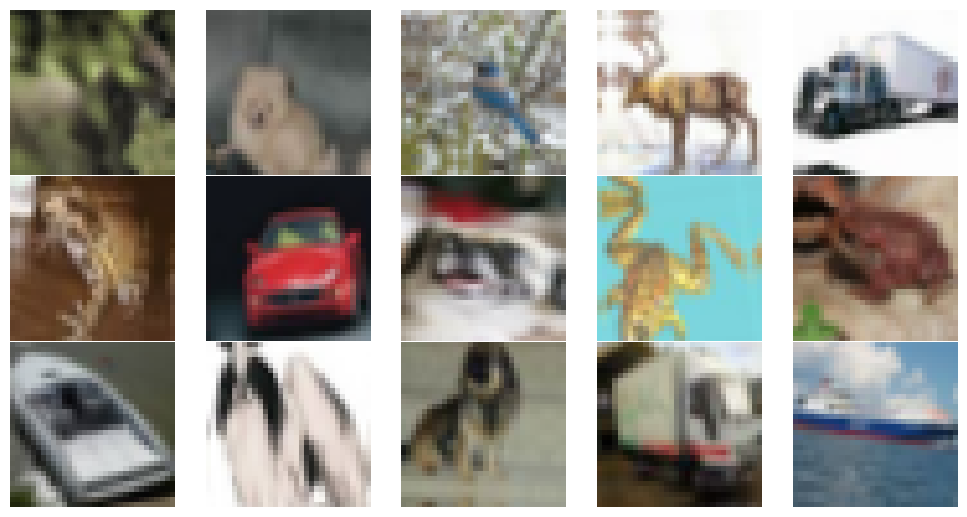

In [ ]:
# My TTA was 0.09, which makes me think there is a disconnect between the types of format for x_train, x_val, or x_test being in the format specified here between -1 and 1 and the TTA notebook where it is simply between 0 and 1.
# So my first step is to try to display the pictures
train_datagen = ImageDataGenerator(
        
       preprocessing_function=revertscale_fn,   #yay that worked
       rescale = 1./255,
       shear_range=0.1,
       zoom_range=0.1,
       horizontal_flip=True,
       rotation_range=10.,
       fill_mode='reflect',
       width_shift_range = 0.1, 
       height_shift_range = 0.1)

train_datagen.fit(x_train)

plt.figure(figsize=(10,5))

for X_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=15):
    for i in range(0, 15):
        plt.subplot(3, 5, i+1)
        plt.imshow(X_batch[i].reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
        plt.axis('off')
    plt.tight_layout(pad=0.1)
    plt.show()
    break

Define the Test Time Image Generator

Keras has predefined choices of [augmentations defined here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) and explained visually well [here](https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844) in a TowardsDataScience Medium Blog Post 

In [ ]:
tta_steps = 50
bs = 64
# epochs = 15

There are the original tried test_datagen that have resulted in the highest accuracy scores:

        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect', 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [ ]:
test_datagen = ImageDataGenerator(
        # preprocessing_function=revertscale_fn,   #hoping this will increase the overall accuracy of TTA from 0.448 to something more similar to the vanilla CNN without TTA - IT DID NOT
        # rescale = 1./255,
        shear_range=-1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect' ,
        width_shift_range = 0.1, 
        height_shift_range = 0.1,
        )

In [ ]:
predictions_tta = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(test_datagen.flow(x_test, batch_size=bs, shuffle=False), steps = len(x_test)/bs)   #Changed X_val to X_test 
    predictions_tta.append(preds)
 

<ipython-input-37-3dcd13f70952>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(tta_steps)):


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# predictions_tta[0][0]   #the first guess of 10 for the 0th image, 1st prob guess is "3" followed by "5"
# predictions_tta[9][0]   #the 9th   guess of 10 for the 0th image, 1st largest prob is "3" followed by "5"
# y_test[0]               #the actual label of the 0th test image is "3" so it would have got this correct.

In [ ]:
final_pred = np.mean(predictions_tta, axis=0)

#final_pred[0] #This is the average guess for image 0, "3" followed by "5"

In [ ]:
# Size of things
#final_pred         # An array of 10000x9 10000 images with 9 classes of probabilities
#predictions_tta    # A list of 11 of  10000 images with 9 classes of probabilities

In [ ]:
# final_pred

pred_tta=np.zeros((len(x_test),9))
pred_max_p_tta=np.zeros((len(x_test)))
pred_std_tta=np.zeros((len(x_test)))
entropy_tta = np.zeros((len(x_test)))


for i in tqdm(range(0,len(x_test))):
  #multi_img=np.tile(x_test[i],(50,1,1,1))
  #preds=model_mc_pred([multi_img,1])
  pred_tta[i]= final_pred[i]
  pred_max_p_tta[i]=np.argmax(final_pred[i]) #mean over n runs of every proba class
  pred_std_tta[i]= np.sqrt(np.sum(np.var(final_pred[i])))
  entropy_tta[i] = -np.sum( pred_tta[i] * np.log2(pred_tta[i] + 1E-14)) #Numerical Stability
pred_labels_tta=np.array([labels_no_horse[np.argmax(pred_tta[i])] for i in range(0,len(pred_tta))])
pred_tta_mean_max_p=np.array([pred_tta[i][np.argmax(pred_tta[i])] for i in range(0,len(pred_tta))])
nll_tta=-np.log(pred_tta_mean_max_p)




# Non-Bayesian copy/paste with final_pred, didn't work... 
# pred_max_p=np.max(final_pred,axis=1)
# entropy_tta=np.array([-np.sum( final_pred[i] * np.log2(final_pred[i] + 1E-14)) for i in range(0,len(final_pred))])
# nll_tta=-np.log(pred_max_p)
# pred_labels_tta=np.array([labels_no_horse[np.argmax(final_pred[i])] for i in range(0,len(final_pred))])
# true_labels=np.array([labels[y_test[i][0]] for i in range(0,len(y_test))])


test_acc_all_tta=np.average(true_labels==pred_labels_tta)
test_acc_known_tta=np.average(true_labels[known_idx]==pred_labels_tta[known_idx])
test_acc_all_tta, test_acc_known_tta

<ipython-input-41-7dede9fced65>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0,len(x_test))):


  0%|          | 0/10000 [00:00<?, ?it/s]

(0.619, 0.6877777777777778)

### Summarize Results So Far

### 🛑  Stop Colab at this point,  if only doing TTA experiments

In [ ]:
while 1: 
  if just_TTA:
    break  
  else:
    print("Continue")


*   .
*   .
*   .
*   .
*   .
*   .







#### Bayesian VI prediction

Here you predict the labels for the bayesian CNN via variational inferce and calculate the uncertainty measures. You predict the same image for 50 times and calculate the mean predicted probabilities, the nll, the entropy and total standart deviation.

In [ ]:
pred_vi=np.zeros((len(x_test),9))
pred_max_p_vi=np.zeros((len(x_test)))
pred_std_vi=np.zeros((len(x_test)))
entropy_vi = np.zeros((len(x_test)))

for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(x_test[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_vi[i]=np.mean(preds,axis=0)#mean over n runs of every proba class
  pred_max_p_vi[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class
  pred_std_vi[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_vi[i] = -np.sum( pred_vi[i] * np.log2(pred_vi[i] + 1E-14)) #Numerical Stability
pred_labels_vi=np.array([labels_no_horse[np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
pred_vi_mean_max_p=np.array([pred_vi[i][np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
nll_vi=-np.log(pred_vi_mean_max_p)

<ipython-input-39-6eebe37ab104>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0,len(x_test))):


  0%|          | 0/10000 [00:00<?, ?it/s]

NameError: ignored

In [ ]:
test_acc_all_vi=np.average(true_labels==pred_labels_vi)
test_acc_known_vi=np.average(true_labels[known_idx]==pred_labels_vi[known_idx])
test_acc_all_vi, test_acc_known_vi

#### Bayesian MC prediction

Here you predict the labels for the bayesian CNN via dropout and calculate the uncertainty measures. You predict the same image for 50 times and calculate the mean predicted probabilities, the nll, the entropy and total standart deviation.

In [ ]:
pred_mc=np.zeros((len(x_test),9))
pred_max_p_mc=np.zeros((len(x_test)))
pred_std_mc=np.zeros((len(x_test)))
entropy_mc = np.zeros((len(x_test)))

for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(x_test[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_mc[i]= np.mean(preds,axis=1)
  pred_max_p_mc[i]=np.argmax(np.mean(preds,axis=1))#mean over n runs of every proba class
  pred_std_mc[i]= np.sqrt(np.sum(np.var(preds, axis=1)))
  entropy_mc[i] = -np.sum( pred_mc[i] * np.log2(pred_mc[i] + 1E-14)) #Numerical Stability
pred_labels_mc=np.array([labels_no_horse[np.argmax(pred_mc[i])] for i in range(0,len(pred_mc))])
pred_mc_mean_max_p=np.array([pred_mc[i][np.argmax(pred_mc[i])] for i in range(0,len(pred_mc))])
nll_mc=-np.log(pred_mc_mean_max_p)

In [ ]:
test_acc_all_mc=np.average(true_labels==pred_labels_mc)
test_acc_known_mc=np.average(true_labels[known_idx]==pred_labels_mc[known_idx])
test_acc_all_mc, test_acc_known_mc

Let's look at the accuarcy on only the knowns and all the labels for all  three models. You cann see that the two bayesian models perform better than the non-bayesian model. Note that the mc-dropout model is the best model in this case.

In [ ]:
import pandas as pd
pd.DataFrame(np.array([[test_acc_known,test_acc_known_vi,test_acc_known_mc, test_acc_known_tta],[test_acc_all,test_acc_all_vi,test_acc_all_mc,  test_acc_all_tta]]), index=['test acc on known labels','test acc on all labels'],columns=['Non-Bayesian','VI','MC','TTA'])

#### Predicted classes for the unknown class
Now you will look a at the unknown class. What are the predicted classes for these images of the horses for each model?

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.bar(np.unique(pred_labels[unknown_idx],return_counts=True)[0],np.unique(pred_labels[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("Non-Bayesian: horses predicted as:")
plt.ylim([0,450])


plt.subplot(1,4,2)
plt.bar(np.unique(pred_labels_tta[unknown_idx],return_counts=True)[0],np.unique(pred_labels_tta[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("With TTA: horses predicted as:")
plt.ylim([0,450])


plt.subplot(1,4,3)
plt.bar(np.unique(pred_labels_vi[unknown_idx],return_counts=True)[0],np.unique(pred_labels_vi[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("VI: horses predicted as:")
plt.ylim([0,450])

plt.subplot(1,4,4)
plt.bar(np.unique(pred_labels_mc[unknown_idx],return_counts=True)[0],np.unique(pred_labels_mc[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("MC: horses predicted as:")
plt.ylim([0,450])


 
plt.show()


As you see in the plot barplot above, most of the horses were classified as deers, which kind of makes sense, because it is the most simlar class to horse. There are also a lot of classifications as dogs or cats.  

#### Compare the predictions for a known and unknown image

Let's compare the predictions of all three models, for a known and an unknown image. For the two bayesian neural network, you will predict the same image for 
50 times and look at the predictive distribution.

In [ ]:
x_test_known = x_test[known_idx]
y_test_known = y_test[known_idx]

x_test_unknown = x_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

np.random.seed(7681)
random_sample_known=np.random.choice(range(0,len(x_test_known)),1)
np.random.seed(2384)
random_sample_unknown=np.random.choice(range(0,len(x_test_unknown)),1)

plt.figure(figsize=(18,12))
plt.subplot(5,3,1)
plt.axis('off')
plt.text(0.5,0.5, "Input image",fontsize=22,horizontalalignment='center')
plt.subplot(5,3,2)
plt.imshow(np.squeeze(np.array(((((x_test_known[random_sample_known])/2)+0.5)*255),dtype="uint8")))
plt.title("known class",fontsize=25)
plt.subplot(5,3,3)
plt.imshow(np.squeeze(np.array(((((x_test_unknown[random_sample_unknown])/2)+0.5)*255),dtype="uint8")))
plt.title("unknown class",fontsize=25)

plt.subplot(5,3,4)
plt.axis('off')
plt.text(0.5,0.5, "Non-Bayesian CNN",fontsize=22,horizontalalignment='center')
plt.subplot(5,3,5)
plt.scatter(range(0,9),model.predict(x_test_known[random_sample_known]),c="blue")
plt.ylabel("P(class)",fontsize=16)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.subplot(5,3,6)
plt.scatter(range(0,9),model.predict(x_test_unknown[random_sample_unknown]),c="blue")
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])

plt.subplot(5,3,7)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via VI",fontsize=22,horizontalalignment='center')
plt.subplot(5,3,8)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_known[random_sample_known]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(5,3,9)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_unknown[random_sample_unknown]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])

plt.subplot(5,3,10)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via dropout",fontsize=22,horizontalalignment='center')


plt.subplot(5,3,11)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_known[random_sample_known],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)


plt.subplot(5,3,12)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_unknown[random_sample_unknown],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])



plt.subplot(5,3,13)
plt.axis('off')
plt.text(0.5,0.5, "CNN with TTA",fontsize=22,horizontalalignment='center')



plt.subplot(5,3,14)
for i in range(0,50):
  plt.scatter(range(0,9), model.predict(test_datagen.flow(x_test_known[random_sample_known], batch_size=1, shuffle=False)), c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)


plt.subplot(5,3,15)
for i in range(0,50):
  plt.scatter(range(0,9), model.predict_generator(test_datagen.flow(x_test_unknown[random_sample_unknown])), c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])



plt.savefig("8.good2.pdf")
plt.show()
#from google.colab import files
#files.download('8.good2.pdf') 

In [ ]:
model.predict_generator(test_datagen.flow(x_test_known[random_sample_known], batch_size=1, shuffle=False))


When you look at the predictions for the unknown calls, you can see the two bayesian neural nets can express their uncertainty better than the non-bayesian net. All three work are quite certain about the known class as you can see in the predictive distributions.

#### Compare the uncertainty measures for all known and unknown classes

Let's compare the uncertainty measures for all images and all three models. Look at the distributions for the known and unknown class. Can you see a difference? You will look at the nll the total standard deviation and the entropy. Note that there is no total standard deviation for the non-bayesian network, because the prediction is always the same, even if you predict the same image for multiple times.

##### Unknown and known classes

In [ ]:
def plot_hists(dist, title, xlabel, xlim=None):
    plt.hist(dist[unknown_idx],bins=30, density=True,alpha = 0.7)
    plt.hist(dist[known_idx],bins=30,  density=True,alpha = 0.7)
    plt.title(title)
    plt.legend(['unknown','known'])
    plt.xlabel(xlabel)
    if xlim != None:
        plt.xlim(xlim)

In [ ]:
plt.figure(figsize=(18,18))

# Non-Bayesian
plt.subplot(4,3,1)
plot_hists(nll_, "Non-Bayesian nll of max p", "NLL", [-0.2,2])
plt.subplot(4,3,2)
plt.axis("off")
plt.subplot(4,3,3)
plot_hists(entropy, "Non-Bayesian entropy", "Entropy", [-0.2,2])

# VI
plt.subplot(4,3,4)
plot_hists(nll_vi, "VI nll of max p", "NLL", [-0.2,2])
plt.subplot(4,3,5)
plot_hists(pred_std_vi, "VI std dev.", "std", [-0.2,0.8])
plt.subplot(4,3,6)
plot_hists(entropy_vi, "VI entropy", "Entropy", [-0.2,3.2])

# MC Methods
plt.subplot(4,3,7)
plot_hists(nll_mc, "MC nll of max p", "NLL", [-0.2,2])
plt.subplot(4,3,8)
plot_hists(pred_std_mc, "MC std dev.", "std", [-0.2,0.8])
plt.subplot(4,3,9)
plot_hists(entropy_mc, "MC entropy", "Entropy", [-0.2,3.2])

# w/TTA Methods
plt.subplot(4,3,10)
plot_hists(nll_tta, "TTA nll of max p", "NLL", [-0.2,2])
plt.subplot(4,3,11)
plot_hists(pred_std_tta, "TTA std dev.", "std", [-0.2,0.8])
plt.subplot(4,3,12)
plot_hists(entropy_tta, "TTA entropy", "Entropy", [-0.2,3.2])




plt.show()

As you can see there is a clear difference in the uncertainty measures between the known and unknown classes. We have lower uncertainties in the known than in the unknown classes. You can also see that the bayesian models are showing higher uncertainties.

### See the impact of TTA on a single image

In [ ]:
image_ix = 20
test_image = x_val[image_ix]
plt.imshow(test_image)
plt.title(f'real label: {np.argmax(y_val[image_ix])}')
plt.axis('off');

In [ ]:
plt.figure(figsize=(20,14))
predictions_tta_idx = []

for i in range(5):
    im = test_datagen.flow(test_image.reshape(1,32,32,3), batch_size=1, shuffle=False)
    im = next(im)
    pred = model.predict(im.reshape(1,32,32,3))
    predictions_tta_idx.append(pred)
    plt.subplot(1, 5, i+1)
    plt.title(f'pred label: {np.argmax(pred)}')
    plt.imshow(im.reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

In [ ]:
final_pred_idx = np.mean(predictions_tta_idx, axis=0)
print(f'final pred: {np.argmax(final_pred_idx)}')

## Use the uncertainty measures as filter

In the next cells you will use the uncertainty measures as filter. You will sort the predicitons by the uncertainty measures and calcualte the accuracy on the n most certrain images. You will compare all three models based on this accuracy vs most certain images plot. To simplify the the sorting and plotting, we first define a the function plot_certainty_idx_filter. 



In [ ]:
def plot_certainty_idx_filter(nr_of_best,certainty_measure,prediction,color,linetype):
  certainty_idx = np.argsort(certainty_measure.reshape(len(certainty_measure)))
  acc_nbest = np.zeros((nr_of_best))
  for j in (range(0,nr_of_best)):
    acc_nbest[j]=np.average(prediction[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
  plt.plot(acc_nbest,c=color,linewidth=2,linestyle=linetype)
  plt.ylim([0.5,1.05])
  plt.ylabel('accuracy',fontsize=14)
  plt.xlabel('Number of Examples taken',fontsize=14)

In [ ]:
plt.figure(figsize=(20,18))
plt.subplot(3,2,1)
plot_certainty_idx_filter(5000,nll_,pred_labels,'black','solid')
plot_certainty_idx_filter(5000,nll_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(5000,nll_mc,pred_labels_mc,'blue','dotted')

plot_certainty_idx_filter(5000,nll_tta,pred_labels_tta,'orange','dashdot')
plt.title('Model Accuracy using p_max and p_mean_max as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'VI',"MC","TTA"], loc='upper right')

plt.subplot(3,2,2)
plot_certainty_idx_filter(10000,nll_,pred_labels,'black','solid')
plot_certainty_idx_filter(10000,nll_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(10000,nll_mc,pred_labels_mc,'blue','dotted')

plot_certainty_idx_filter(10000,nll_tta,pred_labels_tta,'orange','dashdot')
plt.title('Model Accuracy using p_max and p_mean_max as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'VI',"MC","TTA"], loc='upper right')

plt.subplot(3,2,3)
plot_certainty_idx_filter(5000,entropy,pred_labels,'black','solid')
plot_certainty_idx_filter(5000,entropy_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(5000,entropy_mc,pred_labels_mc,'blue','dotted')

plot_certainty_idx_filter(5000,entropy_tta,pred_labels_tta,'orange','dashdot')

plt.title('Model Accuracy using the entropy as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'VI',"MC", "TTA"], loc='upper right')

plt.subplot(3,2,4)
plot_certainty_idx_filter(10000,entropy,pred_labels,'black','solid')
plot_certainty_idx_filter(10000,entropy_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(10000,entropy_mc,pred_labels_mc,'blue','dotted')
plot_certainty_idx_filter(10000,entropy_tta,pred_labels_tta,'orange','dashdot')

plt.title('Model Accuracy using the entropy as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'VI',"MC","TTA"], loc='upper right')

plt.subplot(3,2,5)
plot_certainty_idx_filter(5000,pred_std_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(5000,pred_std_mc,pred_labels_mc,'blue','dotted')
plot_certainty_idx_filter(5000,pred_std_tta,pred_labels_tta,'orange','dashdot')

plt.title('Model Accuracy using the total standard deviation as a filter',fontsize=16)
plt.legend(['VI',"MC","TTA"], loc='upper right')

plt.subplot(3,2,6)
plot_certainty_idx_filter(10000,pred_std_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(10000,pred_std_mc,pred_labels_mc,'blue','dotted')
plot_certainty_idx_filter(10000,pred_std_tta,pred_labels_tta,'orange','dashdot')

plt.title('Model Accuracy using the total standard deviation as a filter',fontsize=16)
plt.legend(['VI',"MC", "TTA"], loc='upper right')
plt.savefig("8.filter.pdf")
plt.show()
#from google.colab import files
#files.download('8.filter.pdf')

You see that both bayesian models outperform the non-bayesian model. This means the bayesian model are more appropriate when you want to have an uncertainty measures. Note again that the mc-dropout model is the best model also in this case.